In [1]:
#Import Modules
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from ModelBuild import buildModel
from ModelBuild import ptetaphi2pxpypz
from ModelBuild import ptetaphi2pxpypz2
from TrackMatcher import matchTracks
from Plotting import binneddensity, fixedbinning
from ModelBuild import flatten1
  
#Set hyperparameters
MASKVAL = 0
MAXTRACKS = 32
BATCHSIZE = 64
EPOCHS = 1500
MAXEVENTS = 99999999999999999
# VALFACTOR = 10
LR = 1e-2

#Open the root file
tree = uproot.open("hffrag.root:CharmAnalysis")

# Decide which branches of the tree we actually want to look at
  # True jet information
jetfeatures=["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi"]

# true b-hadron information
# these b-hadrons are inside the truth jets
bhadfeatures=["AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
  
# reconstructed track information
trackfeatures=[ "AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]

# Read in the requested branches from the file
features = tree.arrays(jetfeatures + trackfeatures, entry_stop=MAXEVENTS)

#Data Processing
events = features[awkward.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

jets1 = events[jetfeatures][:,0] #First jet
tracks = events[trackfeatures]

matchedtracks = tracks[matchTracks(jets1, tracks)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS) #Turn into regular np array

bjets = awkward.sum(jets1["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0 #Find b hadron jets with certain momentum
jets2 = jets1[bjets] #Jets identified as b jets are only jets considered
bhadspt= jets2["AnalysisAntiKt4TruthJets_ghostB_pt"][:,0] #np Stack here - Each sub array contains all the features of the jet (axis -1)
bhadseta = jets2["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0]
bhadsphi = jets2["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0]
matchedtracks = matchedtracks[bjets]

jets3 = structured_to_unstructured(jets2[jetfeatures[:-3]]) #number of features
matchedtracks = structured_to_unstructured(matchedtracks)

jets4 = ptetaphi2pxpypz(jets3).to_numpy()
tracks = ptetaphi2pxpypz2(matchedtracks.to_numpy())
tracks = np.concatenate([tracks, matchedtracks[:,:,3:].to_numpy()], axis = 2)
bhadspt = bhadspt.to_numpy()
bhadseta = bhadseta.to_numpy()
bhadsphi = bhadsphi.to_numpy()
bhads = np.stack([bhadspt, bhadseta], axis=-1)

tracklayers = [ 32 , 32 , 32 , 32 , 32 ]
jetlayers = [ 64 , 64 , 64 , 64 , 64 ]
trackfeatures =["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
model = buildModel([len(trackfeatures)] + tracklayers, jetlayers, 2)
model.load_weights('Model Weights.h5')

matchedtracks = matchedtracks.to_numpy()

#Convert bhads characteristics to cartesian
bhadscart = np.stack([bhadspt, bhadseta, bhadsphi], axis=-1)
bhadscart = ptetaphi2pxpypz(bhadscart)

2022-11-29 14:31:05.303867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 14:31:05.453404: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 14:31:05.457896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 14:31:05.457912: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
%matplotlib inline

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(tracks, bhads, train_size = 0.75)
pred = model.predict(tracks)
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

533/533 [==============================] - 1s 1ms/step


In [4]:
pTDiff=pred[:,0] - bhads[:,0]
pTErr= np.exp(pred[:,2])
pTPull = pTDiff/pTErr

etaDiff = pred[:,1] - bhads[:,1]
etaErr = np.exp(pred[:, 3])
etaPull = etaDiff/etaErr

In [6]:
trackpT = np.sum(matchedtracks[:,:,0], axis = 1)

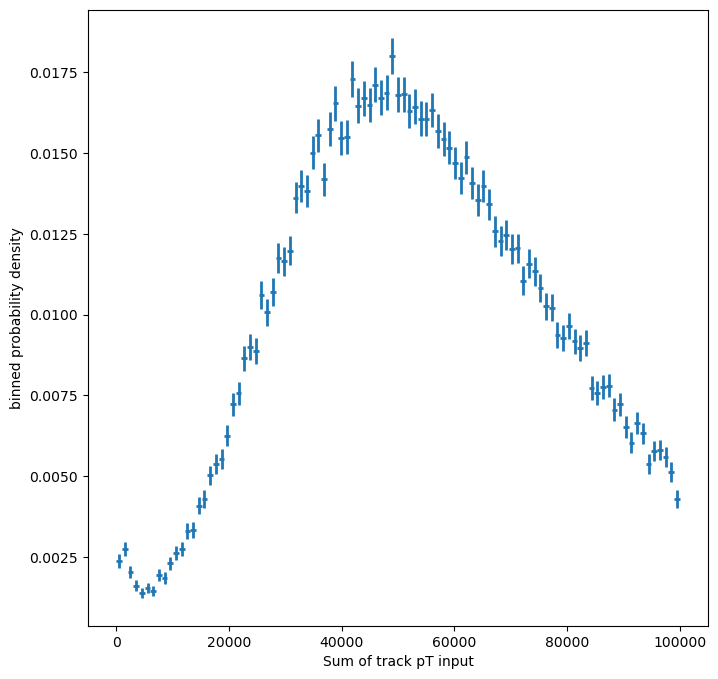

In [7]:
#Plot the sum of pTs input into model
fig = binneddensity(trackpT, fixedbinning(0.1, 100000, 100), xlabel = 'Sum of track pT input')
#fig

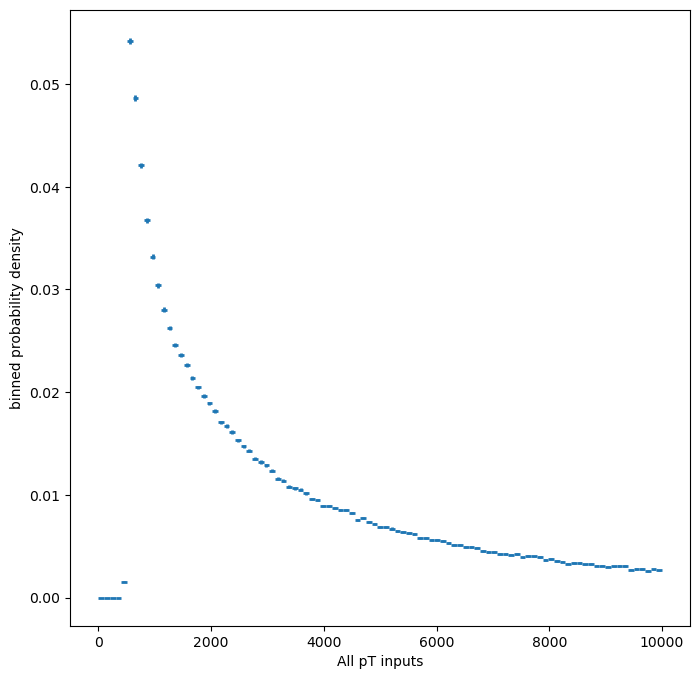

In [8]:
#Plot every track pT input into model
fig = binneddensity(matchedtracks[:,:,0], fixedbinning(0.00001,10000,100), xlabel = 'All pT inputs (MeV)')
fig

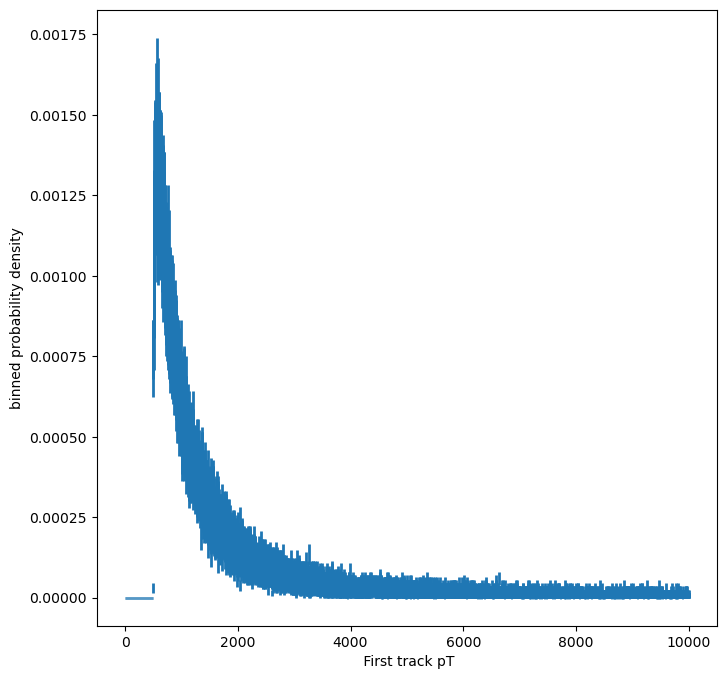

In [9]:
#Plot first track pT values
fig = binneddensity(features["AnalysisTracks_pt"][:,0],fixedbinning(0,10000,10000),xlabel = " First track pT")
fig

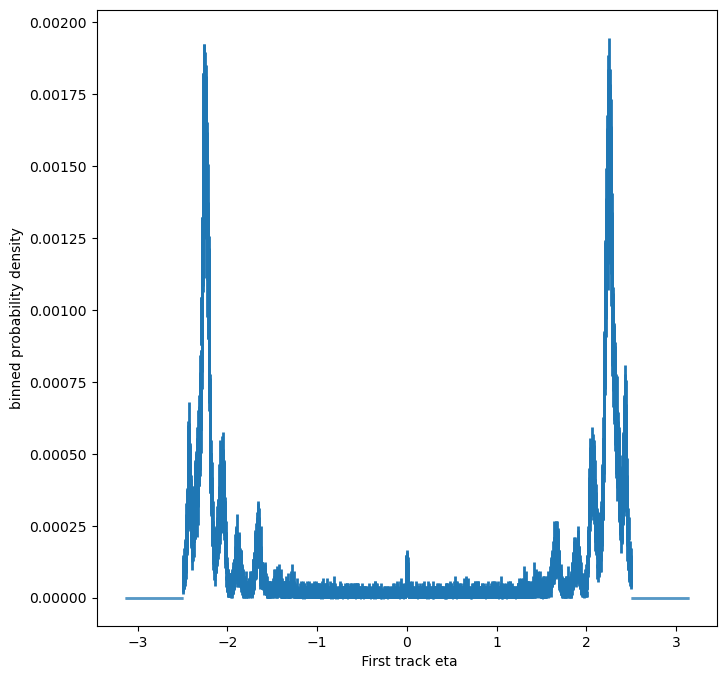

In [10]:
#Plot first track eta values
fig = binneddensity(features["AnalysisTracks_eta"][:,0],fixedbinning(-np.pi,np.pi,10000),xlabel = " First track eta")
fig

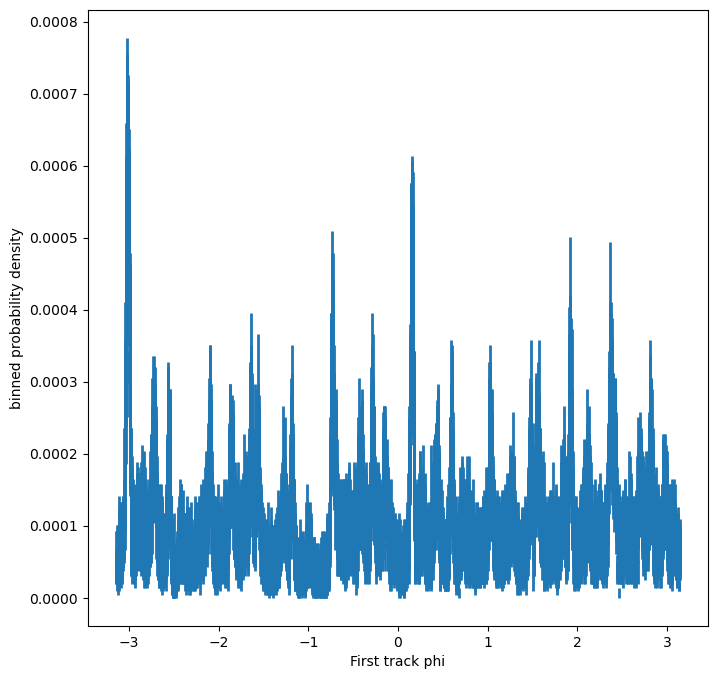

In [11]:
#Plot first track phi values
fig = binneddensity(features["AnalysisTracks_phi"][:,0],fixedbinning(-np.pi,np.pi,10000),xlabel = "First track phi")
#fig

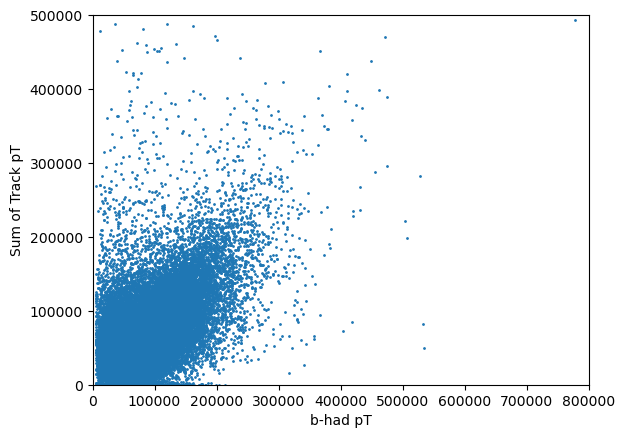

In [69]:
# Creating plot
plt.scatter(bhads[:,0], trackpT, s=1)
plt.xlabel('b-had pT')
plt.ylabel('Sum of Track pT')
plt.xlim([0,800000])
plt.ylim(([0, 500000]))
# show plot
plt.show()


In [109]:
trackpx = np.sum(tracks[:,:,0], axis = 1)
trackpy = np.sum(tracks[:,:,1], axis = 1)
trackpz = np.sum(tracks[:,:,2], axis = 1)
pxmasked_list = []
pymasked_list = []
pzmasked_list = []
pxprop = trackpx/bhadscart[:,0]
pyprop = trackpy/bhadscart[:,1]
pzprop = trackpz/bhadscart[:,2]
for x in range(len(trackpx)):
    pxmask = (trackpy[x]!=0)
    pxmasked_list.append(pxmask)
    pymask = (trackpy[x]!=0)
    pymasked_list.append(pymask)
    pzmask = (trackpz[x]!=0)
    pzmasked_list.append(pzmask)
trackpx = trackpx[pxmasked_list]
trackpy = trackpy[pymasked_list]
trackpz = trackpz[pzmasked_list]

bhadspx = bhadscart[:,0]
bhadspy = bhadscart[:,1]
bhadspz = bhadscart[:,2]

bhadspx = bhadspx[pxmasked_list]   
bhadspy = bhadspy[pymasked_list]
bhadspz = bhadspz[pzmasked_list]

print(np.shape(bhadspx), np.shape(bhadspy), np.shape(bhadspz))
print(np.shape(trackpx), np.shape(trackpy), np.shape(trackpz))


(66738,) (66738,) (66738,)
(66738,) (66738,) (66738,)


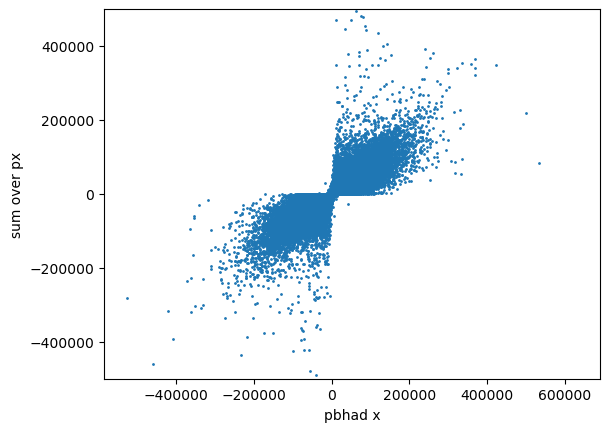

In [105]:
# Creating plot
plt.scatter(bhadspx, trackpx, s=1)
plt.xlabel('pbhad x')
plt.ylabel('sum over px')
plt.ylim(([-500000, 500000]))
plt.show()


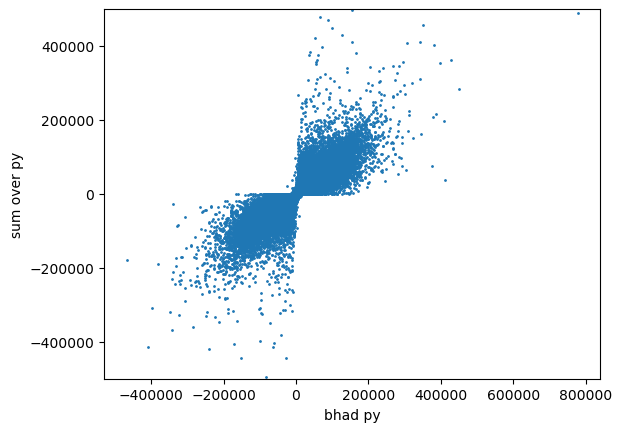

In [106]:
# Creating plot
plt.scatter(bhadspy, trackpy, s=1)
plt.xlabel('bhad py')
plt.ylabel('sum over py')
plt.ylim(-500000,500000)
plt.show()

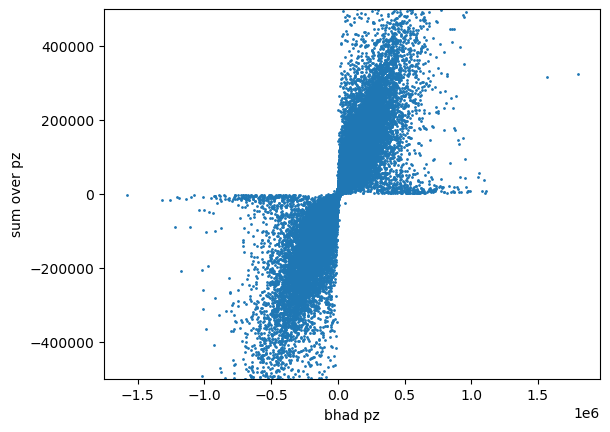

In [111]:
# Creating plot
plt.scatter(bhadspz, trackpz, s=1)
plt.xlabel('bhad pz')
plt.ylabel('sum over pz')
plt.ylim(-500000,500000)
plt.show()

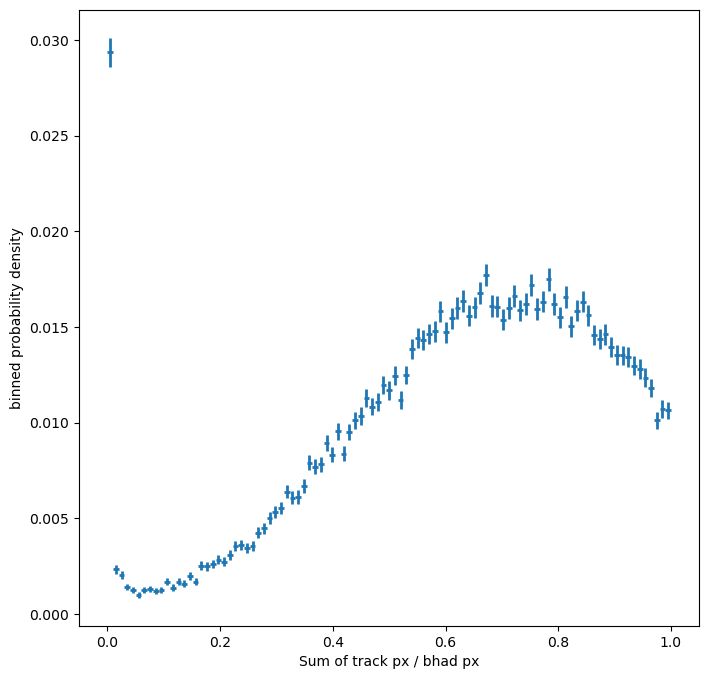

In [17]:
fig = binneddensity(pxprop, fixedbinning(0,1,100) ,xlabel = 'Sum of track px / bhad px')
fig

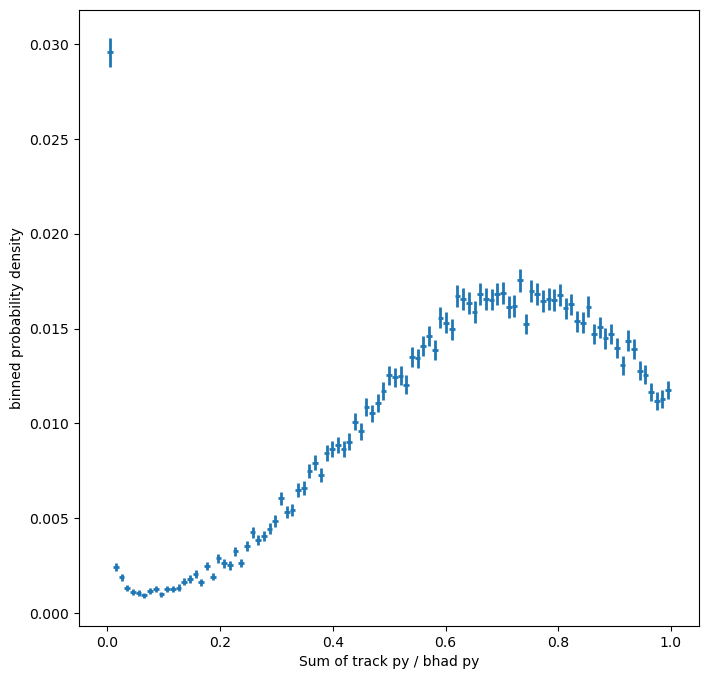

In [18]:
fig = binneddensity(pyprop, fixedbinning(0,1,100) ,xlabel = 'Sum of track py / bhad py')
fig

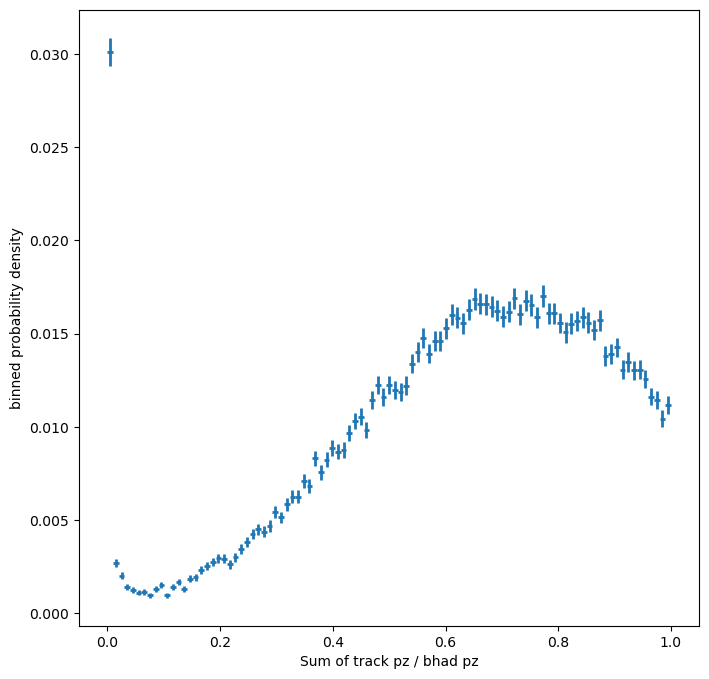

In [19]:
fig = binneddensity(pzprop, fixedbinning(0,1,100) ,xlabel = 'Sum of track pz / bhad pz')
fig

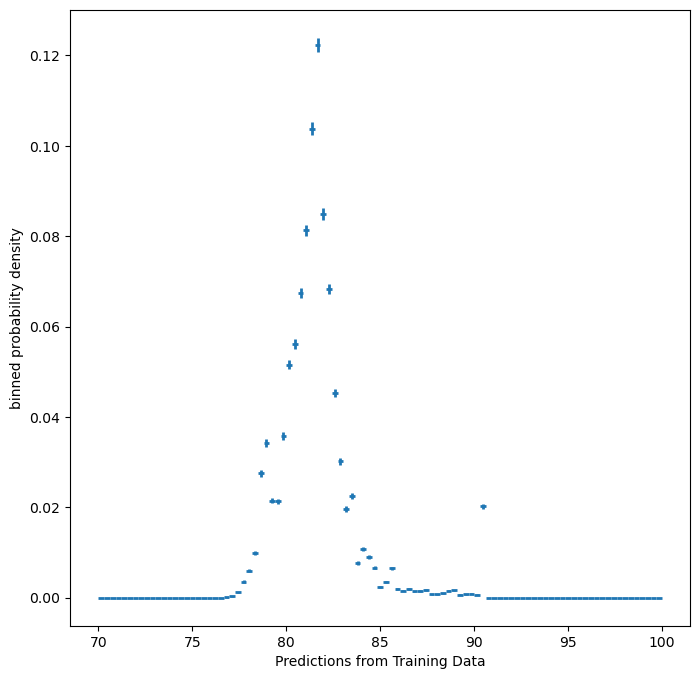

In [20]:
fig=binneddensity(train_pred[:,0], fixedbinning(70, 100, 100), xlabel="Predictions from Training Data")
fig

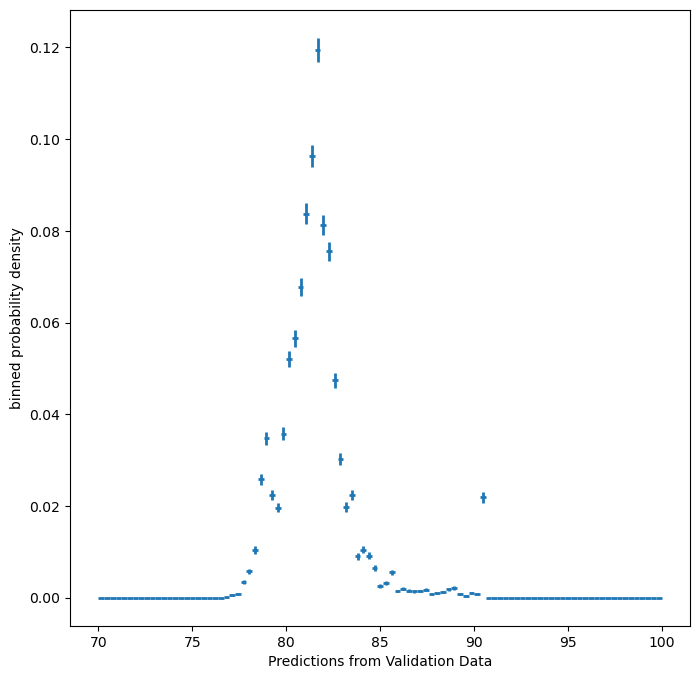

In [21]:
fig=binneddensity(valid_pred[:,0], fixedbinning(70, 100, 100), xlabel="Predictions from Validation Data")
fig

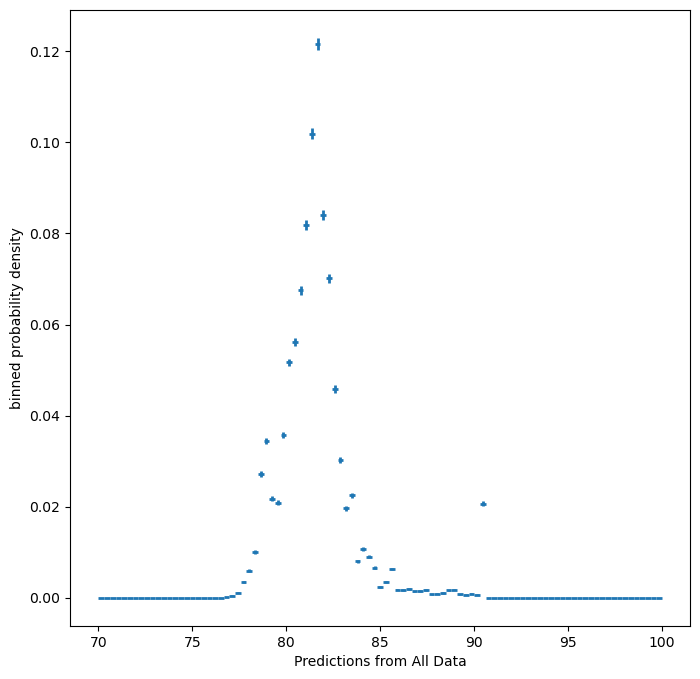

In [22]:
fig =binneddensity(pred[:,0], fixedbinning(70, 100, 100), xlabel="Predictions from All Data")
fig


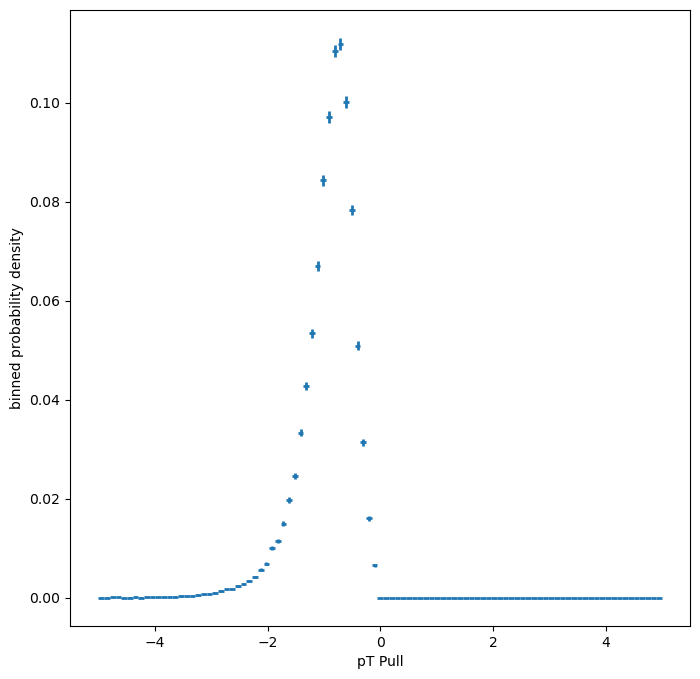

In [23]:
fig = \
binneddensity \
( pTPull
, fixedbinning(-5, 5, 100)
, xlabel="pT Pull"
)
fig.savefig("pT Pull.png")
fig

In [24]:
jetz0sintheta = features["AnalysisTracks_z0sinTheta"]
impactParam = features["AnalysisTracks_d0"]
impactParamSig = features["AnalysisTracks_d0sig"]
impactParamPV = features["AnalysisTracks_d0PV"]
impactParamPVSig = features["AnalysisTracks_d0sigPV"]

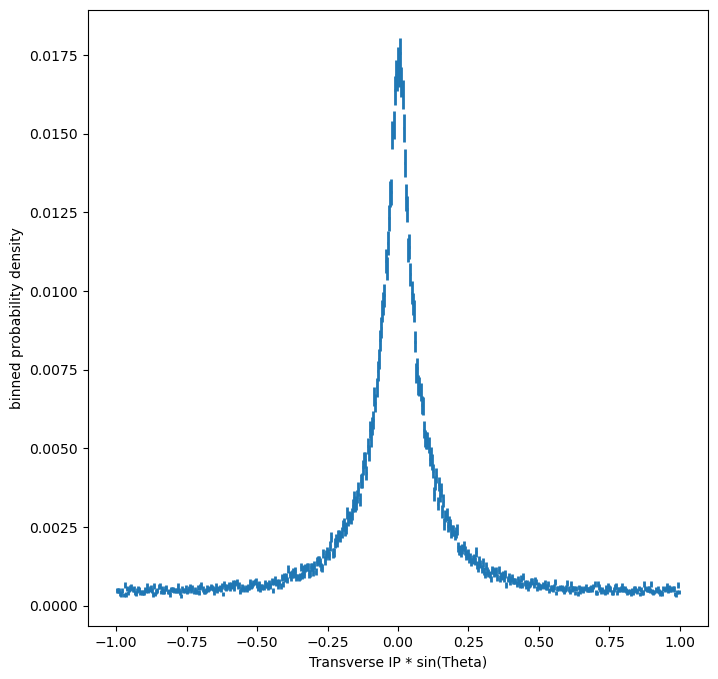

In [25]:
fig = \
  binneddensity \
  ( jetz0sintheta[:,0] # the first jet in each event
  , fixedbinning(-1, 1, 500) # 50 bins from 0 to 2
  , xlabel="Transverse IP * sin(Theta)"
  )
fig.savefig("TransverseIP.png")
fig

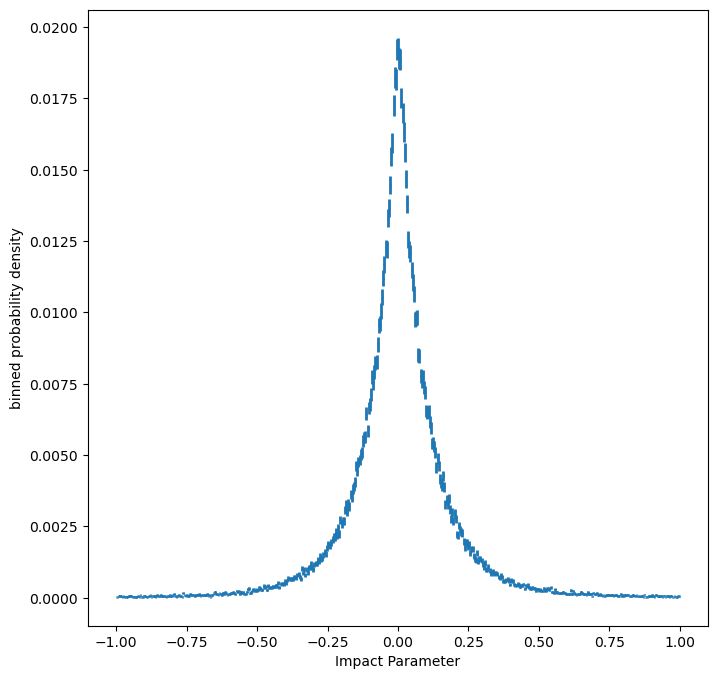

In [26]:
fig = \
  binneddensity \
  ( impactParam[:,0] # the first jet in each event
  , fixedbinning(-1, 1, 500) # 50 bins from 0 to 2
  , xlabel="Impact Parameter"
  )
fig.savefig("Impact Parameter.png")
fig

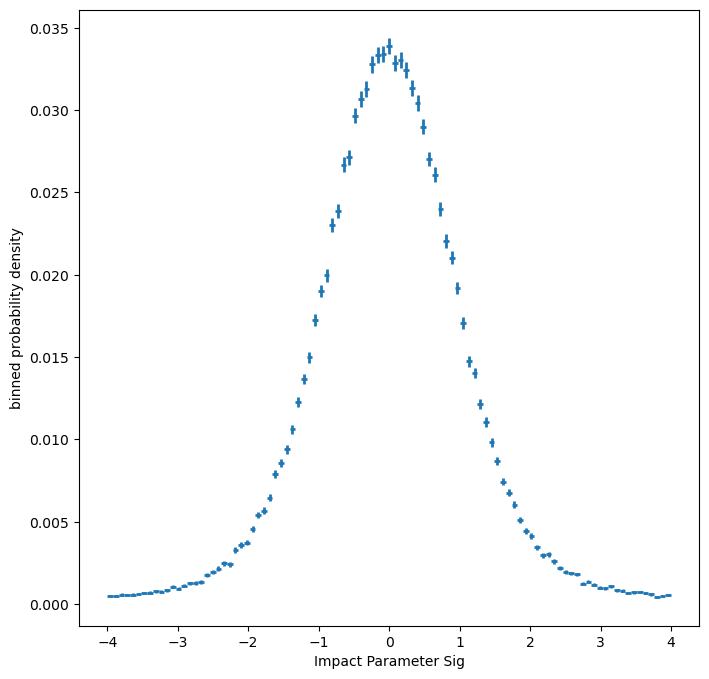

In [27]:
fig = \
  binneddensity \
  ( impactParamSig[:,0] # the first jet in each event
  , fixedbinning(-4, 4, 100) # 50 bins from 0 to 2
  , xlabel="Impact Parameter Sig"
  )
fig.savefig("Impact Parameter Sig.png")
fig

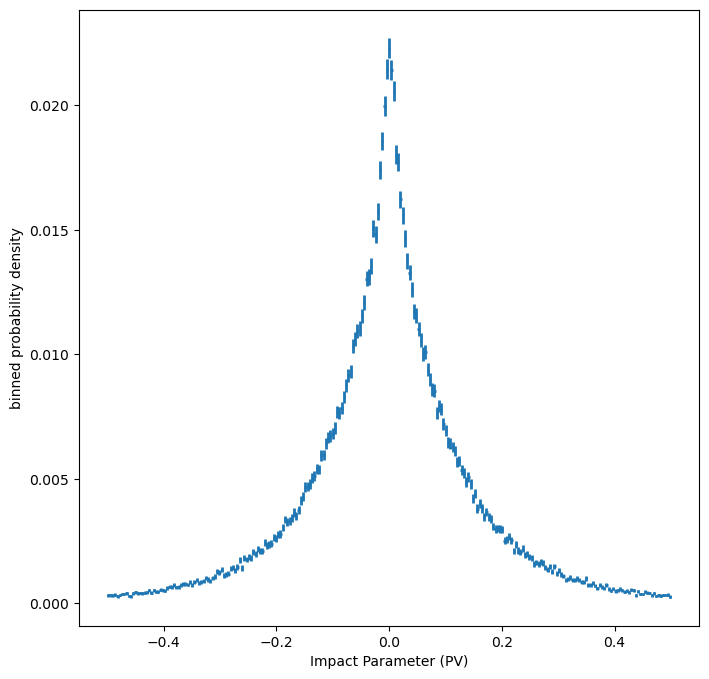

In [28]:
fig = \
  binneddensity \
  ( impactParamPV[:,0] # the first jet in each event
  , fixedbinning(-0.5, 0.5, 250) # 50 bins from 0 to 2
  , xlabel="Impact Parameter (PV)"
  )
fig.savefig("Impact Parameter PV.png")
fig

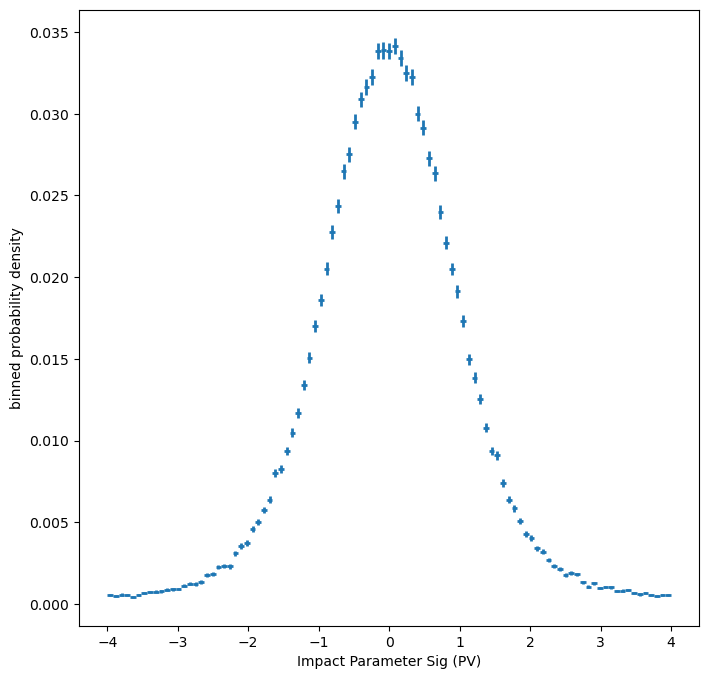

In [29]:
fig = \
  binneddensity \
  ( impactParamPVSig[:,0] # the first jet in each event
  , fixedbinning(-4, 4, 100) # 100 bins from -3 to 3
  , xlabel="Impact Parameter Sig (PV)"
  )
fig.savefig("Impact Parameter PV Sig.png")
fig

In [30]:
#TODO
#Plot d0PV, d0PVsig, d0, d0sig, z0sintheta, px, py, pz, phi
#Use data from before masks were added